TODO 

- proofread

In [29]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

import os
os.chdir('/big/st/strasserl/spapros/docs')

from IPython.display import HTML, display, Image, HTML

from IPython.core.display import HTML

css = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(css))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Spapros Tutorial: Advanced Selection

This tutorial shows how to select a gene probeset with spapros.  
Next to the basic procedure, we explain several advanced use cases.
Additionally, the parameters are discussed. 

The used dataset contains 3k PBMCs from a healthy donor and is publicly available from
[10x Genomics](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)
[here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz).

You can also derive it from scanpy [here](https://scanpy.readthedocs.io/en/stable/generated/scanpy.datasets.pbmc3k.html#scanpy.datasets.pbmc3k), like we will do in this tutorial.

The preprocessed Anndata consists of log-normalized single cell RNAseq counts of 2638 cells 1838 genes.

**Content**  

0. [Import packages and setup](#0.-Import-packages-and-setup)  
1. [Load dataset](#1.-Load-dataset)  
2. [Prepare penalties](#2.-Prepare-penalties)  
3. [Use cases](#3.-Use-cases)  
    i. [Standard selection](#i.-Standard-selection)  
    ii. [Select few additional genes](#ii.-Select-few-additional-genes)  
    iii. [Cell type classification only](#iii.-Cell-type-classification-only)  
    iv. [Selection with curated marker list](#iv.-Selection-with-curated-marker-list)  
4. [Reference probeset selection](#4.-Reference-probeset-selection)     
5. [What's next](5.-#What's-next)  

<a id="Import-packages-and-setup"></a>

## 0. Import packages and setup

To run the notebook locally, create a conda environment using this [yaml file](../requirements_dev.yaml):

    conda create -f environment.yaml

Then add the conda environment as ipython kernel:

    python -m ipykernel install --user --name spapros --display-name Python (spapros)

In [2]:
import spapros
from spapros import se, ev, pl
from IPython.display import clear_output
import scanpy as sc
import pandas as pd
import os
import yaml
import matplotlib as mpl

In [3]:
sc.settings.verbosity = 0
sc.logging.print_header()
print(f"spapros=={spapros.__version__}")

scanpy==1.8.2 anndata==0.8.0 umap==0.5.2 numpy==1.21.5 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.6
spapros==0.1.0


## 1. Load dataset

In [4]:
adata = sc.datasets.pbmc3k()
adata_tmp = sc.datasets.pbmc3k_processed()
adata = adata[adata_tmp.obs_names,adata_tmp.var_names]
adata_raw = adata.copy()
sc.pp.normalize_total(adata,target_sum=1e4,key_added="size_factors")
sc.pp.highly_variable_genes(adata,flavor="cell_ranger",n_top_genes=1000)
adata.X = adata_raw.X
sc.pp.log1p(adata)
adata.obs['celltype'] = adata_tmp.obs['louvain']
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'size_factors', 'celltype'
    var: 'gene_ids', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'

## 2. Prepare penalties

In [5]:
# TODO

**PCA**

pca_penalties:  
        List of keys for columns in `adata.var` containing penalty factors that are multiplied with the
        scores for PCA based gene selection.
        
penalty_keys:  
        List of keys for columns in adata.var that are multiplied with the scores.
        
corr_penalty:  
        Function that maps values from [0,1] to [0,1]. It describes an iterative penalty function
        that is applied on pca selected genes. The highest correlation with already selected genes
        to the next selected genes are penalized according the given function. (max correlation is
        recomputed after each selected gene).
        
        
        
**DE**  

DE_penalties:  
        List of keys for columns in `adata.var` containing penalty factors that are multiplied with the 
        scores for DE based gene selection.
          
m_penalties_adata_celltypes:  
        List of keys for columns in `adata.var` containing penalty factors to filter out marker genes if a 
        gene's penalty < threshold for celltypes in adata.
          
m_penalties_list_celltypes:  
        List of keys for columns in `adata.var` containing penalty factors to filter out marker genes if a 
        gene's penalty < threshold for celltypes not in adata.

## 3. Use cases

We will go through some uses cases for gene selection, starting with the basic procedure.

### i. Standard selection

#### a. Set up the ProbesetSelector


In [6]:
# create an instance of the ProbesetSelector class
selector = se.ProbesetSelector(adata, 
                            n=50, 
                            celltype_key="celltype", 
                            verbosity=1, 
                            save_dir=None)

The following celltypes' test set sizes for forest training are below min_test_n (=20):
	 Dendritic cells : 9
	 Megakaryocytes  : 3


TODO  
parameter discussion   
interesting pararms could be:   

```
marker: 
    marker_corr_th
    n_list_markers: 
        Minimal number of markers per celltype that are at least selected. Selected means 
        either selecting genes from the marker list or having correlated genes in the 
        already selected panel. (Set the correlation threshold with 
        marker_selection_hparams['penalty_threshold']). If you want to select a different 
        number of markers for celltypes in adata and celltypes only in the marker
        list, set e.g.: n_list_markers = {'adata_celltypes':2,'list_celltypes':3}

penalties:
    m_penalties_adata_celltypes
    m_penalties_list_celltypes
    min_mean_difference:
        Minimal difference of mean expression between at least one celltype and the 
        background. In this test only cell types from `celltypes` are taken into account 
        (also for the background). This minimal difference is applied as an additional 
        binary penalty in pca_penalties, DE_penalties and m_penalties_adata_celltypes.
    pca_penalties
    DE_penalties
    marker_penalties

```



#### b. Start the selection

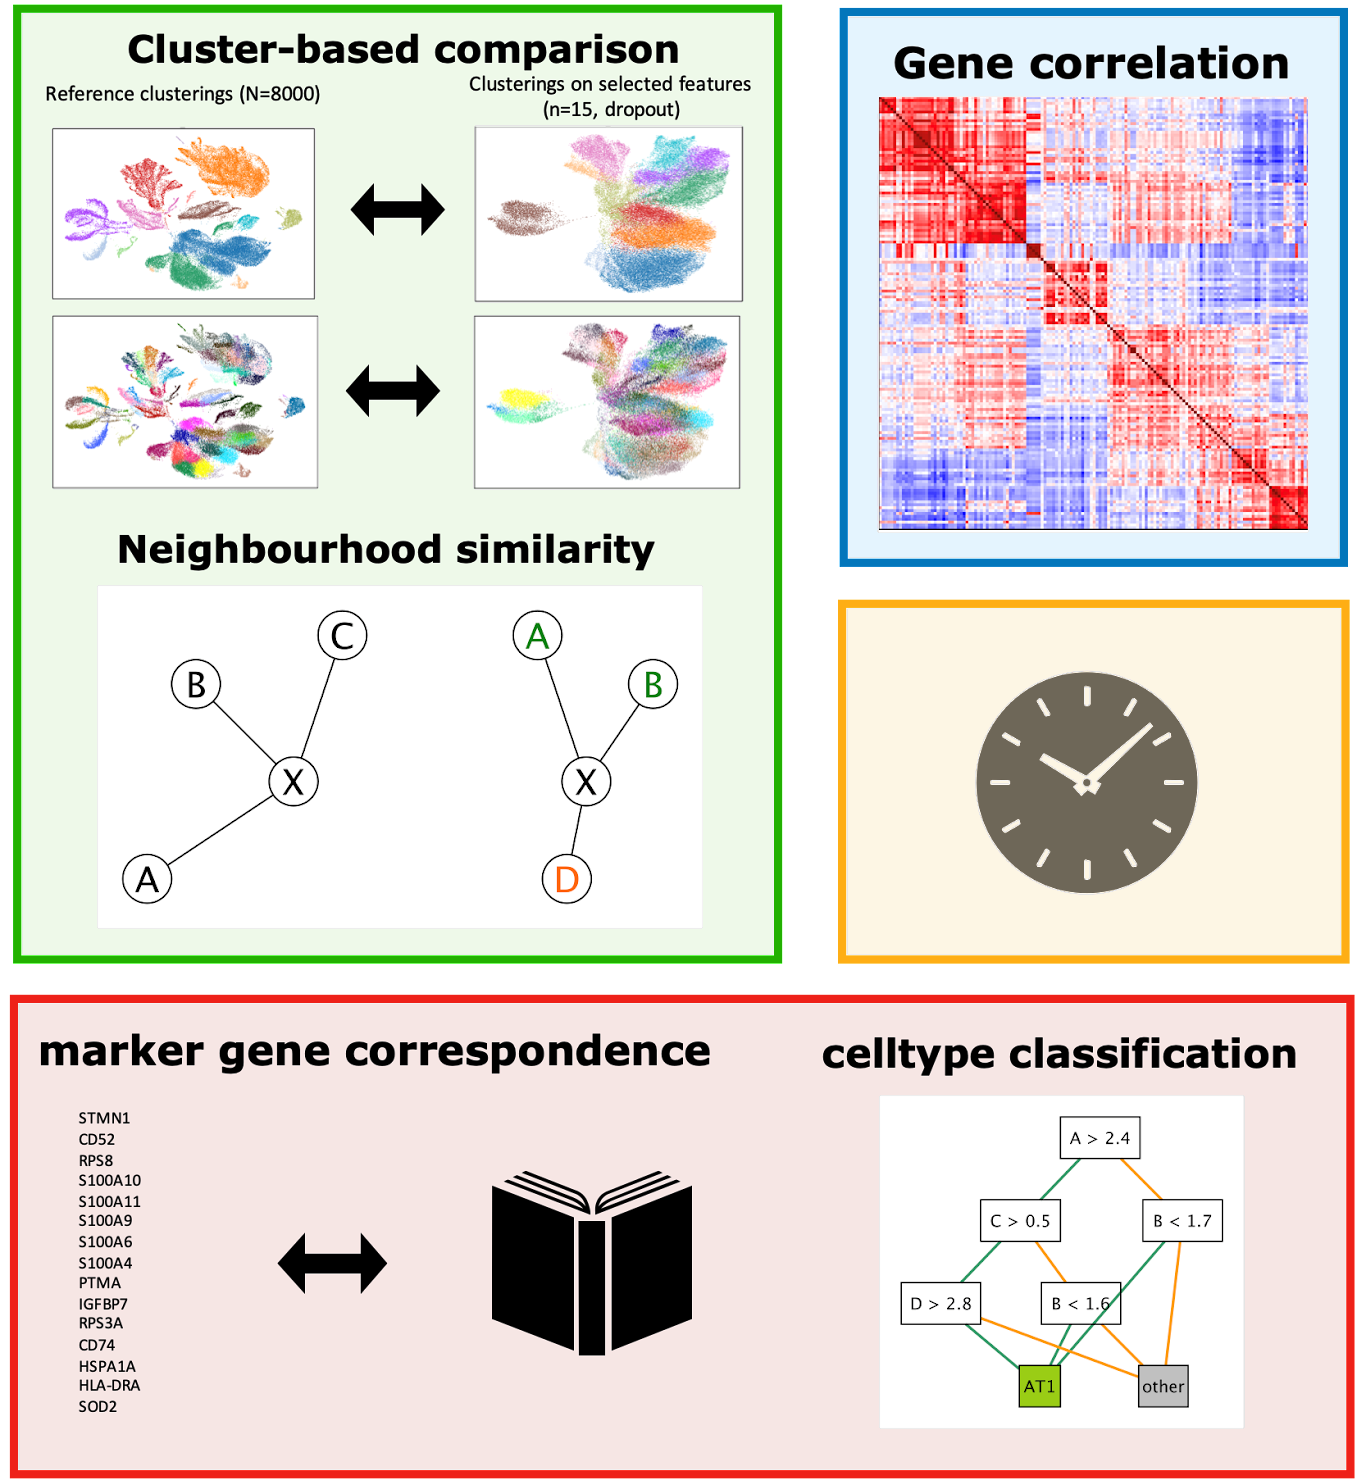

In [7]:
Image("../tutorials/abstract_figures/fig_01.png", width=300, height=300, embed=True)

In [8]:
# TODO
# rough description of the spapros selection pipeline

In [9]:
selector.select_probeset()


Output()

The selected probeset can be examined like this: 

In [10]:
selector.probeset

,gene_nr,selection,rank,marker_rank,tree_rank,importance_score,pca_score,pre_selected,prior_selected,pca_selected,celltypes_DE_1vsall,celltypes_DE_specific,celltypes_DE,celltypes_marker,list_only_ct_marker,required_marker,required_list_marker
PPBP,1,True,1.0,1.0,1.0,1.000000,1.182710,False,False,True,Megakaryocytes,,Megakaryocytes,Megakaryocytes,False,True,False
LST1,2,True,1.0,1.0,1.0,0.749666,1.574997,False,False,True,FCGR3A+ Monocytes,,FCGR3A+ Monocytes,FCGR3A+ Monocytes,False,True,False
HLA-DQA1,3,True,1.0,1.0,1.0,0.608147,1.034986,False,False,True,B cells,,B cells,B cells,False,True,False
GZMB,4,True,1.0,1.0,1.0,0.527486,1.317827,False,False,True,NK cells,,NK cells,NK cells,False,True,False
HLA-DRB1,5,True,1.0,1.0,1.0,0.432876,1.365428,False,False,True,Dendritic cells,,Dendritic cells,Dendritic cells,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RP11-178G16.4,996,False,NaN,NaN,NaN,NaN,0.011824,False,False,False,,,,,False,False,False
RP11-324I22.4,997,False,NaN,NaN,NaN,NaN,0.011760,False,False,False,,,,,False,False,False
SYP,998,False,NaN,NaN,NaN,NaN,0.011548,False,False,False,,,,,False,False,False
RP11-252A24.3,999,False,NaN,NaN,NaN,NaN,0.010570,False,False,False,,,,,False,False,False


#### c. Vizualize the results

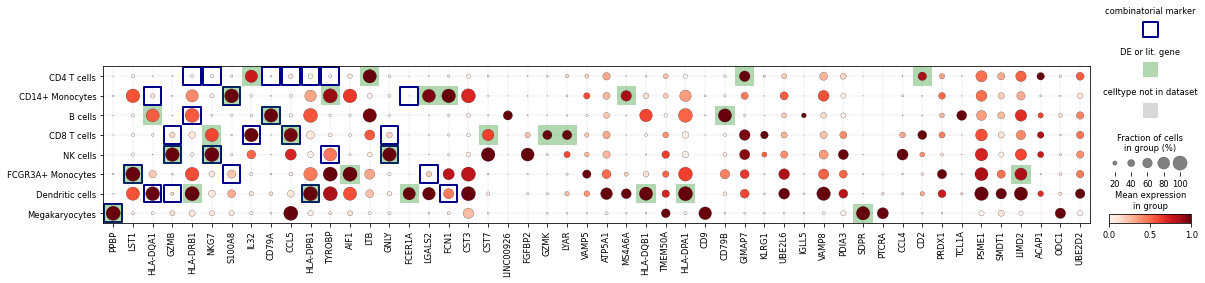

In [11]:
pl.masked_dotplot(adata, selector)

### ii. Select few additional genes

In cases where already some genes of interest are known, one might want to add only a few additional genes to create a probeset. For such a use case, the spapros selection pipeline provides the parameters 'preselected_genes' and 'prior_genes'. The 'preselected_genes' will be the highest ranked genes in the probeset list. The 'prior_genes' are prioretized during the selection process but will not be necessarily part of the probeset. 

In [12]:
preselected_genes = selector.probeset[selector.probeset["selection"]].index[:20].to_list()
prior_genes = selector.probeset[selector.probeset["selection"]].index[20:40].to_list()

In [13]:
# create an instance of the ProbesetSelector class
selector = se.ProbesetSelector(adata, 
                            n=50, 
                            celltype_key="celltype", 
                            verbosity=1, 
                            save_dir=None, 
                            preselected_genes=preselected_genes,
                            prior_genes=prior_genes)

The following celltypes' test set sizes for forest training are below min_test_n (=20):
	 Dendritic cells : 9
	 Megakaryocytes  : 3


In [14]:
selector.select_probeset()

Output()

In [15]:
# venn diagramm?

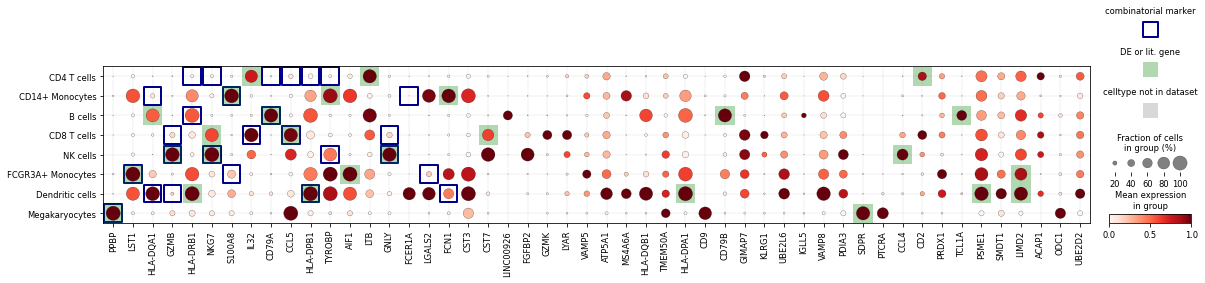

In [16]:
pl.masked_dotplot(adata, selector)

### iii. Cell type classification only

In [17]:
# TODO

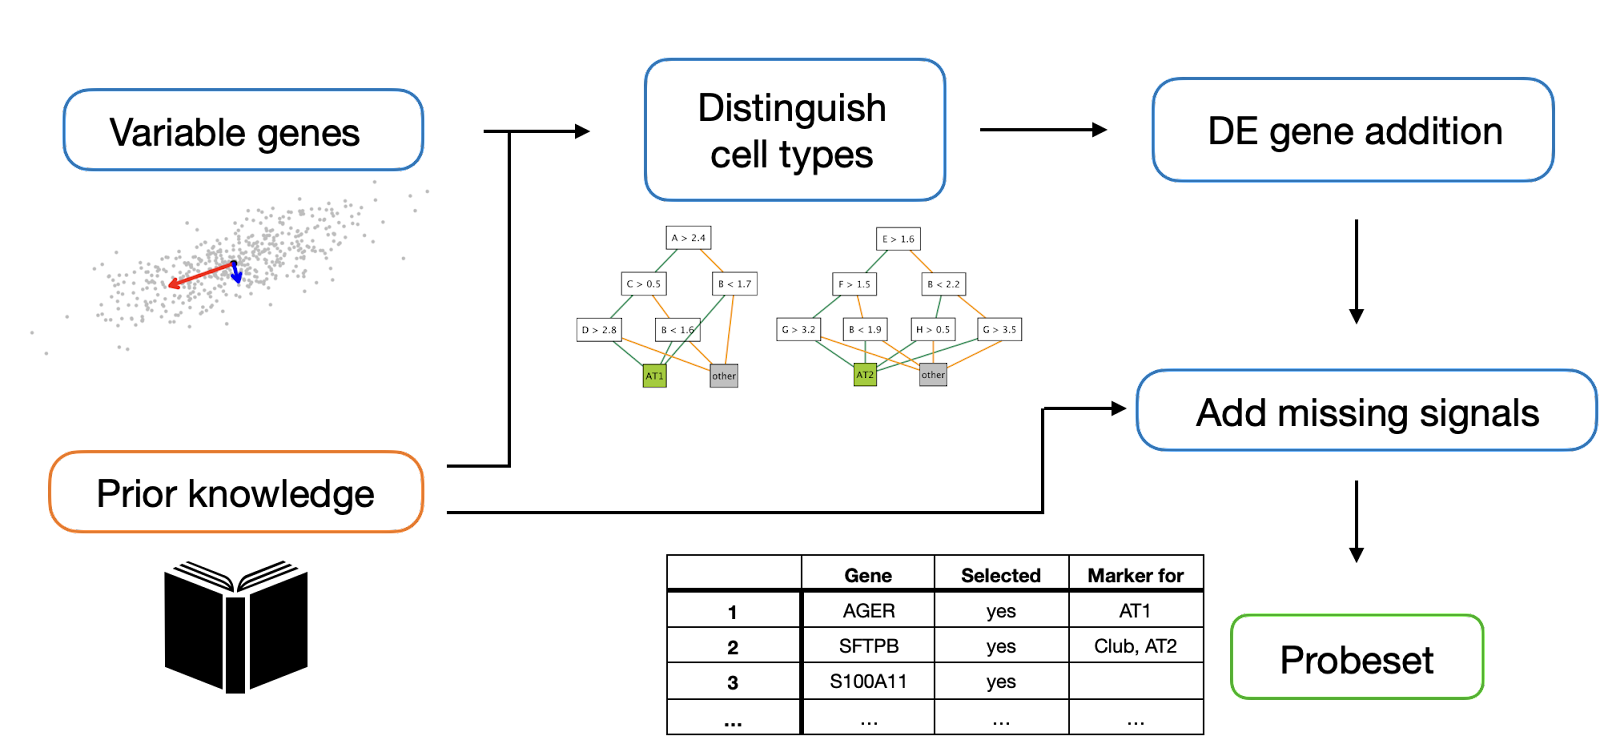

In [18]:
Image("../tutorials/abstract_figures/fig_03.png", width=500, embed=True)

In [19]:
selector = se.ProbesetSelector(adata, 
                            n=50, 
                            celltype_key="celltype", 
                            verbosity=1, 
                            save_dir=None, 
#                             DE_selection_hparams={"per_group": True}, 
#                             n_pca_genes=0
                            )

The following celltypes' test set sizes for forest training are below min_test_n (=20):
	 Dendritic cells : 9
	 Megakaryocytes  : 3


### iv. Selection with curated marker list

Select genes from a marker list based on correlations with already selected genes. The following list was taken from this [scanpy tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html).

In [20]:
marker_list = {'CD4 T cells': ['IL7R'], 'CD14+ Monocytes': ['CD14', 'LYZ'], 'B cells': ['MS4A1'], 'CD8 T cells': ['CD8A'], 'NK cells': ['GNLY', 'NKG7'], 'FCGR3A+ Monocytes': ['FCGR3A', 'MS4A7'], 'Dendritic cells': ['FCER1A', 'CST3'], 'Megakaryocytes': ['NAPA-AS1', 'PPBP']}
marker_list

{'CD4 T cells': ['IL7R'],
 'CD14+ Monocytes': ['CD14', 'LYZ'],
 'B cells': ['MS4A1'],
 'CD8 T cells': ['CD8A'],
 'NK cells': ['GNLY', 'NKG7'],
 'FCGR3A+ Monocytes': ['FCGR3A', 'MS4A7'],
 'Dendritic cells': ['FCER1A', 'CST3'],
 'Megakaryocytes': ['NAPA-AS1', 'PPBP']}

In [21]:
selector = se.ProbesetSelector(adata, 
                            n=50, 
                            celltype_key="celltype", 
                            verbosity=1, 
                            save_dir=None, 
                            marker_list=marker_list)

The following celltypes' test set sizes for forest training are below min_test_n (=20):
	 Dendritic cells : 9
	 Megakaryocytes  : 3
Filter out genes in marker dict that occur multiple times.


In [22]:
selector.select_probeset()

Output()

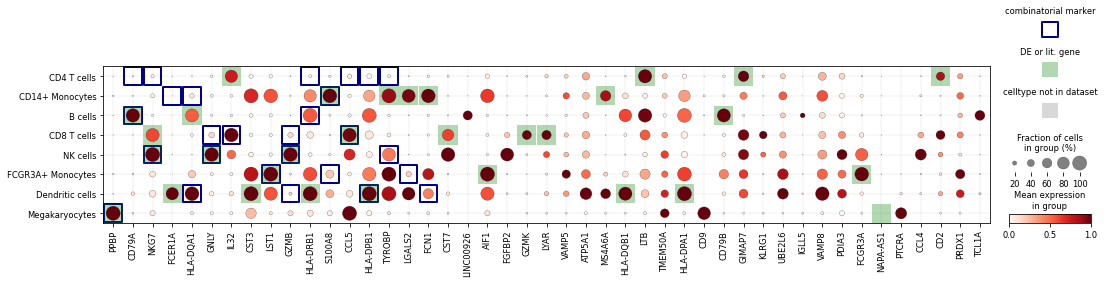

In [23]:
pl.masked_dotplot(adata, selector)

Fields highlighted in green mark markers from the curated list or differentially expressed genes.  

## 4. Reference probeset selection

After selecting probesets, they should be evaluated. As a reference, basic selection methods based on PCA, DE, variability or random can be used. Spapros integrates a quick method for these four attempts:  


With the method `select_reference_probesets` you can easily select reference probesets.
By default, 4 sets are created: 

- `pca_selection`: PCA based selection
- `hvg_selection`: Selection of highly variable genes
- `de_selection`: Differentially expressed genes selection
- `random_selection`: Random gene selection

The selection methods can be altered with the parameter `reference_selections`. 
It takes a dictionary, where the keys are the wanted selection method names and the values are their hyper parameters. 

An easy way to select several random gene sets is provided by the parameter `seeds`, which takes a list of seeds. Each list entry is used as seed for one random gene set selection. 

In [24]:
reference_sets = se.select_reference_probesets(adata, 50, verbosity=2, seeds=[1, 2, 3])

Output()

In [25]:
display(reference_sets["ref_HVG"].head())  
display(reference_sets["ref_PCA"].head())
display(reference_sets["ref_random (seed=1)"].head())

,selection
index,
CPSF3L,False
ATAD3C,True
RER1,False
TNFRSF25,False
TNFRSF9,False


,selection,selection_score,selection_ranking
index,,,
CPSF3L,False,0.125340,419.0
ATAD3C,False,0.038324,864.0
RER1,False,0.358249,124.0
TNFRSF25,False,0.183054,287.0
TNFRSF9,False,0.042982,840.0


,selection
index,
CPSF3L,False
ATAD3C,False
RER1,False
TNFRSF25,False
TNFRSF9,False


In [26]:
display(reference_sets["ref_DE"].head())  

,selection,CD4 T cells,CD14+ Monocytes,B cells,CD8 T cells,NK cells,FCGR3A+ Monocytes,Dendritic cells,Megakaryocytes
index,,,,,,,,,
CPSF3L,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATAD3C,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RER1,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TNFRSF25,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TNFRSF9,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
merged_df = pd.DataFrame()
for ref_name, ref_df in reference_sets.items(): 
    merged_df[ref_name] = ref_df.index[ref_df.selection]
merged_df.head()

,ref_HVG,ref_PCA,ref_DE,ref_random (seed=1),ref_random (seed=2),ref_random (seed=3)
0,ATAD3C,CAPZB,CAPZB,UBIAD1,RP11-70P17.1,S100A8
1,C1QC,CD2,CD2,PGM1,TAL1,IL24
2,ZNF436,S100A8,S100A8,CHI3L2,HDGF,RP1-28O10.1
3,SPOCD1,CD48,FCER1A,KIAA0040,CD48,VAMP8
4,C2CD4D,SELL,GNLY,RP11-378J18.3,RNF187,TMEM40


## 5. What's next? 



See our [basic evaluation tutorial](https://spapros.readthedocs.io/en/latest/tutorials/spapros_tutorial_basic_evaluation.html) or our [advanced evaluation tutorial](https://spapros.readthedocs.io/en/latest/tutorials/spapros_tutorial_advanced_evaluation.html) for detailed instructions to evaluate the selected probesets.